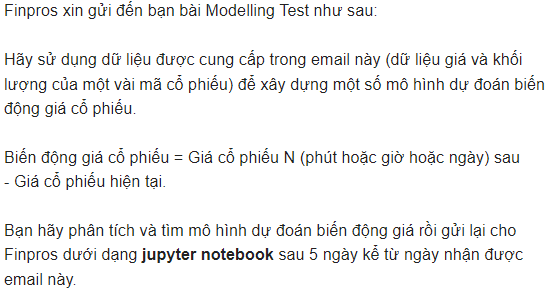

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns


In [2]:
# Warning Removal
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

In [3]:
df1 = pd.read_csv('C:\\Users\\Administrator\\Downloads\\finprostest\\MSN.csv')
df2 = pd.read_csv('C:\\Users\\Administrator\\Downloads\\finprostest\\PNJ.csv')
df3 = pd.read_csv('C:\\Users\\Administrator\\Downloads\\finprostest\\VIC.csv')
df4 = pd.read_csv('C:\\Users\\Administrator\\Downloads\\finprostest\\FPT.csv')

In [4]:
df1.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,MSN,12/25/2017 9:15,73.1,73.1,73.1,73.1,4210,0
1,MSN,12/25/2017 9:16,73.0,73.0,73.0,73.0,5000,0
2,MSN,12/25/2017 9:18,73.5,73.5,73.5,73.5,210,0
3,MSN,12/25/2017 9:20,73.2,73.5,73.1,73.1,2050,0
4,MSN,12/25/2017 9:21,73.0,73.0,73.0,73.0,1380,0


In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135354 entries, 0 to 135353
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ticker         135354 non-null  object 
 1   Date/Time      135354 non-null  object 
 2   Open           135354 non-null  float64
 3   High           135354 non-null  float64
 4   Low            135354 non-null  float64
 5   Close          135354 non-null  float64
 6   Volume         135354 non-null  int64  
 7   Open Interest  135354 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 8.3+ MB


In [6]:
df1.describe()

,Open,High,Low,Close,Volume,Open Interest
count,135354.000000,135354.000000,135354.000000,135354.000000,1.353540e+05,135354.0
mean,74.878809,74.931668,74.834625,74.880759,5.683578e+03,0.0
std,15.418074,15.426954,15.412677,15.418857,2.798513e+04,0.0
min,46.500000,46.500000,46.400000,46.400000,1.000000e+01,0.0
25%,57.900000,57.900000,57.800000,57.800000,5.000000e+02,0.0
50%,79.100000,79.200000,79.100000,79.100000,2.000000e+03,0.0
75%,86.000000,86.100000,86.000000,86.000000,5.560000e+03,0.0
max,117.800000,118.000000,117.700000,118.000000,3.300680e+06,0.0


In [7]:
def clean_data(df):
    # drop None value
    df.dropna(inplace=True)
    # drop duplicated row
    df.drop_duplicates(inplace=True)
    # Change Date/Time type from object to datetime
    df['Date/Time'] = pd.to_datetime(df['Date/Time'])
    # Select only Y - M - D
    df['Date'] = df['Date/Time'].dt.date
    # Group by day to fit the model
    data = df.groupby(['Date'], as_index=False).agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    })
    data['Ticker'] = df.Ticker[1]
    # Add column represent Price fluctuation
    data['Change'] = data['Close'].shift(-1) - data['Close']
    # Add column represent the number of days to the next nearest trading day
    data['NextDay'] = data['Date'].shift(-1) - data['Date']
    data['NextDay'] = data['NextDay'].dt.days
    # Add the column Close price of the next nearest trading day
    data['NextClose'] = data['Close'].shift(-1)
    # Drop the last and the first because it contain NaN
    data = data[1:-1]
    # As far as I research, the 4 given stocks are traded on HoSE,
    # price fluctuation can not exceed 7% compare to the closest previous Close price
    return data

In [8]:
df1=clean_data(df1)
df2=clean_data(df2)
df3=clean_data(df3)
df4=clean_data(df4)
combined = pd.concat([df1,df2,df3,df4])
combined

,Date,Open,High,Low,Close,Volume,Ticker,Change,NextDay,NextClose
1,2017-12-26,74.9,75.5,74.3,75.5,403710,MSN,-0.5,1.0,75.0
2,2017-12-27,74.9,75.7,74.8,75.0,517920,MSN,0.7,1.0,75.7
3,2017-12-28,75.0,76.0,74.5,75.7,377030,MSN,1.0,1.0,76.7
4,2017-12-29,76.0,77.0,76.0,76.7,226880,MSN,3.3,4.0,80.0
5,2018-01-02,77.0,80.0,76.7,80.0,533950,MSN,2.5,1.0,82.5
...,...,...,...,...,...,...,...,...,...,...
493,2020-12-15,57.5,57.5,56.6,56.7,2666900,FPT,0.4,1.0,57.1
494,2020-12-16,57.2,57.5,57.0,57.1,1995530,FPT,-0.6,1.0,56.5
495,2020-12-17,56.9,57.0,56.0,56.5,3594500,FPT,0.4,1.0,56.9
496,2020-12-18,56.5,57.0,56.5,56.9,1532820,FPT,0.6,3.0,57.5


<AxesSubplot:>

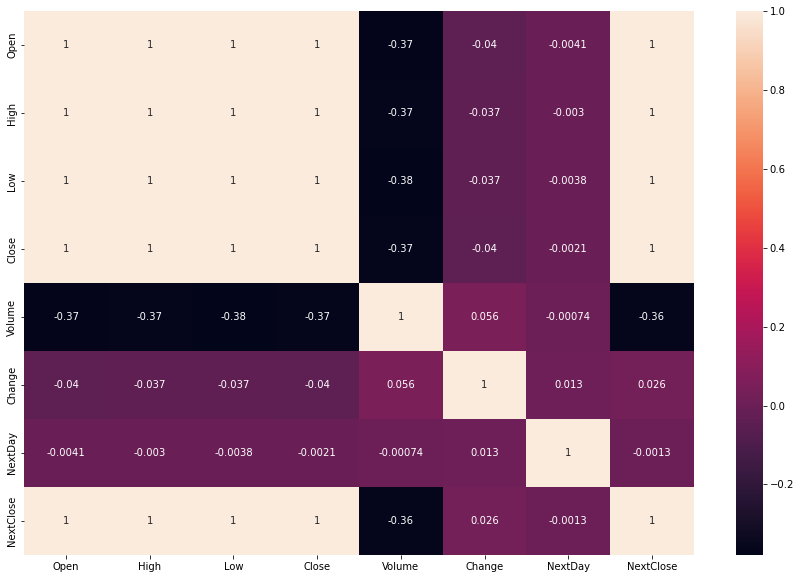

In [9]:
plt.figure(figsize=(15,10))
sns.heatmap(combined.corr(),annot=True)

In [10]:
# readmeplz

# So I think of 2 way can be executed:
#     - Directly: Chose Price fluctuation ('Change' column) as target variable. 
#     But the correlation of itself with other variable is low ~0.4%. This can 
#     lead to the problem of unstable and imprecise model.
#     - Indirectly: Measure the next Close Price, subtract this number to the 
#     current close price to get the price's change. In this case, we might not
#     take variable Open, High, Low, Close into consideration because their 
#     correlation parameter equal to 1 (which lead to Mutilcollinearity), also
#     the Change and NextDay var with low percentage. The model will only use 
#     one variable is Volume
# So my choice is Indirect method

# 1. Linear Regression

Training model

In [11]:
from sklearn.linear_model import LinearRegression

In [12]:
# Target var
y = combined['NextClose']
# Predictor var
X = combined[['Volume']]
# Split data to training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 22)
#Create a Linear Regressor
lm = LinearRegression()
#Training the model by training set
lm.fit(X_train,y_train)
coef = pd.DataFrame(lm.coef_,index = X_train.columns, columns=['Coefficient'])

Model Evaluation

R^2: 0.147720948304791
MAE: 16.918316611829702
MSE: 448.0342622508493
RMSE: 21.166819842641672


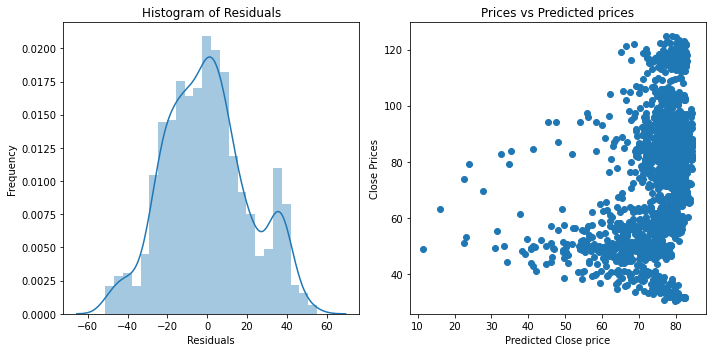

In [13]:
def evaluate_model(y_pred, y_train, X_train):
    fig, ax= plt.subplots(1,2,figsize=(10,5))
    sns.distplot((y_train-y_pred),ax= ax[0])
    # Checking Normality of errors
    ax[0].set_title("Histogram of Residuals")
    ax[0].set_xlabel("Residuals")
    ax[0].set_ylabel("Frequency")
    # The difference between actual close and predicted close price
    ax[1].scatter(y_pred,y_train)
    ax[1].set_ylabel("Close Prices")
    ax[1].set_xlabel("Predicted Close price")
    ax[1].set_title("Prices vs Predicted prices")
    plt.tight_layout()
    # Model Evaluation
    print('R^2:',metrics.r2_score(y_train,y_pred))
    print('MAE:', metrics.mean_absolute_error(y_train, y_pred))
    print('MSE:', metrics.mean_squared_error(y_train, y_pred))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_pred)))
    return plt.show()

# Model prediction on train data
y_pred = lm.predict(X_train)
evaluate_model(y_pred,y_train, X_train)

Model tend to predict price between 70-80 while the residual distribution is Gauss-like

For test data

In [14]:
# Predicting Test data with the model
y_test_pred = lm.predict(X_test)

lin = pd.DataFrame([
    metrics.r2_score(y_test, y_test_pred),
    metrics.mean_absolute_error(y_test, y_test_pred),
    metrics.mean_squared_error(y_test, y_test_pred),
    np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
],
                   columns=['LinearRegression'],
                   index=['R^2', 'MAE', 'MSE', 'RMSE'])
lin

,LinearRegression
R^2,0.091526
MAE,17.693247
MSE,488.221994
RMSE,22.095746


# 2. Random Forest Regressor

Training model

In [15]:
# Import Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest Regressor
reg2 = RandomForestRegressor()

# Train the model using the training sets 
reg2.fit(X_train, y_train)

RandomForestRegressor()

Evaluate Model

R^2: 0.8292082844634072
MAE: 7.343843443544945
MSE: 89.7834343303318
RMSE: 9.475412092902967


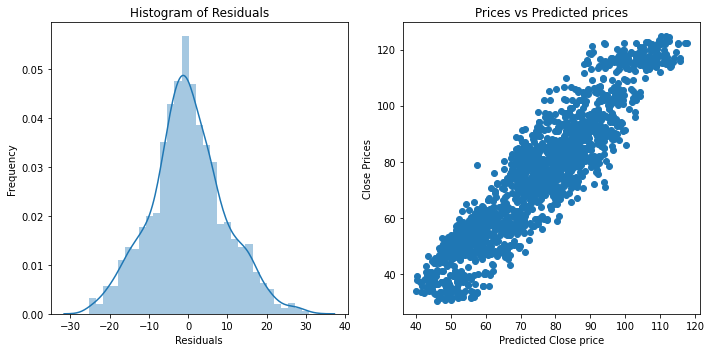

In [16]:
y_pred = reg2.predict(X_train)
evaluate_model(y_pred, y_train, X_train)

Residuals are normal distributed and predicted price is close to actual

For test data

In [17]:
# Predicting Test data with the model
y_test_pred = reg2.predict(X_test)

rf = pd.DataFrame([
    metrics.r2_score(y_test, y_test_pred),
    metrics.mean_absolute_error(y_test, y_test_pred),
    metrics.mean_squared_error(y_test, y_test_pred),
    np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
],
                   columns=['RandomForest'],
                   index=['R^2', 'MAE', 'MSE', 'RMSE'])
rf

,RandomForest
R^2,-0.217307
MAE,20.060104
MSE,654.191548
RMSE,25.577168


# 3. SVM Regressor

In [18]:
from sklearn import svm
reg3 = svm.SVR()
reg3.fit(X_train, y_train)

SVR()

R^2: 0.18536091937580257
MAE: 15.87774042245025
MSE: 428.2473196568702
RMSE: 20.69413732574688


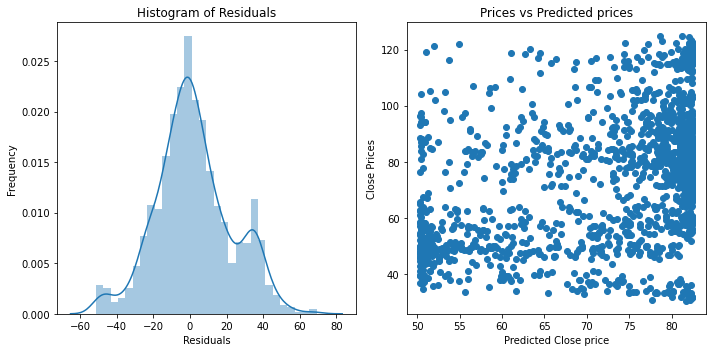

In [19]:
y_pred = reg3.predict(X_train)
evaluate_model(y_pred, y_train, X_train)

The real price and predicted are not close, residual can be consider as Normal distribution

In [20]:
# Predicting Test data with the model
y_test_pred = reg3.predict(X_test)

sv = pd.DataFrame([
    metrics.r2_score(y_test, y_test_pred),
    metrics.mean_absolute_error(y_test, y_test_pred),
    metrics.mean_squared_error(y_test, y_test_pred),
    np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
],
                   columns=['SVM'],
                   index=['R^2', 'MAE', 'MSE', 'RMSE'])
sv

,SVM
R^2,0.144078
MAE,16.680582
MSE,459.980149
RMSE,21.447148


# 4. XGBoost Regressor

In [21]:
# Import XGBoost Regressor
from xgboost import XGBRegressor

#Create a XGBoost Regressor
reg4 = XGBRegressor()
# Train the model using the training sets 
reg4.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

R^2: 0.324397673989512
MAE: 14.864336794682348
MSE: 355.1571390931188
RMSE: 18.845613258610577


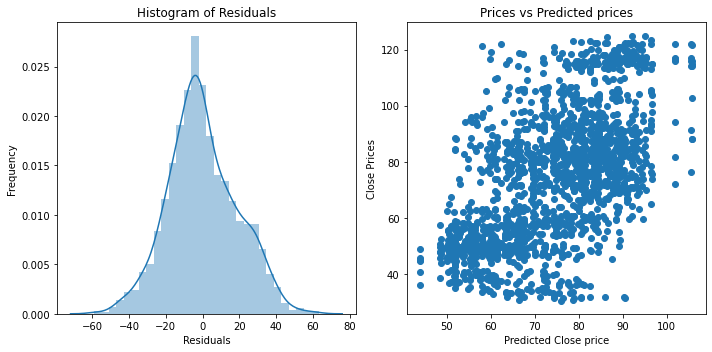

In [22]:
y_pred = reg4.predict(X_train)
evaluate_model(y_pred, y_train, X_train)

Residuals are Normal distribution

In [23]:
# Predicting Test data with the model
y_test_pred = reg4.predict(X_test)

xgb = pd.DataFrame([
    metrics.r2_score(y_test, y_test_pred),
    metrics.mean_absolute_error(y_test, y_test_pred),
    metrics.mean_squared_error(y_test, y_test_pred),
    np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
],
                   columns=['XGBoost'],
                   index=['R^2', 'MAE', 'MSE', 'RMSE'])
xgb

,XGBoost
R^2,0.053459
MAE,17.773989
MSE,508.679603
RMSE,22.553927


# 5. Compare 4 model

In [24]:
compare = pd.concat([lin,rf,sv,xgb],axis=1)
compare

,LinearRegression,RandomForest,SVM,XGBoost
R^2,0.091526,-0.217307,0.144078,0.053459
MAE,17.693247,20.060104,16.680582,17.773989
MSE,488.221994,654.191548,459.980149,508.679603
RMSE,22.095746,25.577168,21.447148,22.553927


So clearly Support Vector Machine Regressor work better for this dataset.

I was recommend to use k-fold to evaluate the performance of the model but im not understand it thoroughly =)). Im not sure my code is good enougn or not, so i hope to receive your feedbacks and advices whatever the outcome of the application. Best regards. 
